# Building the network
This is the notebook that I used to build the network. Everything here is not intended as implementation but just to track my thought process as I was developing the thing on itself (yep, like Kant)

In [1]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set(font_scale=3.0)

#### Parameters

In [2]:
# Structure paramters
N = 200  # Inputs size
n = 200  # C3 size
v = 100.0   # Input - C3 connection
b = 100.0   # Input - C1 connection
Kr = 1.0   # Recurrent self-inhibition gain
Ki = 1.0   # Input - C3 inhibition
Ci = 1.0  # Inhibition from the input to C1
Cr = 1.0  # Inhibition from C3 to C1
p = 0.4   # Sparness parameter

# Dynamical parameters
theta = 0.0
phi = 0


# Learning rate
epsilon = 0.1

# Dynamical quantities
m = 0.0  # Number of neurons active on C3
s = 0.0  # Number of active inputs

#### Building the connectivity matrix

I need to build the matrix c, there are two ways to build them. And maybe I will need two of them

In [3]:
# Let's build the matrix of connections c_ij
c1 = np.random.choice(2, size=(n, n), replace=True, p=[1 - p, p])
c2 = np.random.binomial(n=1, p=p, size=(N, n))

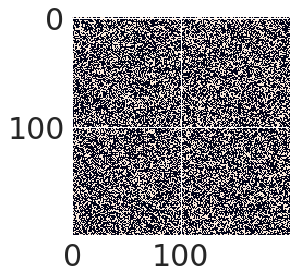

In [4]:
plt.imshow(c1)

In [5]:
np.sum(c1, axis=1) / n

array([ 0.44 ,  0.45 ,  0.42 ,  0.39 ,  0.34 ,  0.43 ,  0.38 ,  0.38 ,
        0.41 ,  0.42 ,  0.42 ,  0.395,  0.445,  0.35 ,  0.455,  0.425,
        0.45 ,  0.35 ,  0.395,  0.405,  0.45 ,  0.375,  0.39 ,  0.41 ,
        0.445,  0.385,  0.44 ,  0.38 ,  0.41 ,  0.4  ,  0.385,  0.41 ,
        0.42 ,  0.405,  0.375,  0.32 ,  0.365,  0.385,  0.41 ,  0.415,
        0.415,  0.42 ,  0.425,  0.35 ,  0.455,  0.38 ,  0.365,  0.415,
        0.395,  0.395,  0.405,  0.415,  0.455,  0.345,  0.435,  0.405,
        0.4  ,  0.455,  0.425,  0.38 ,  0.41 ,  0.42 ,  0.39 ,  0.415,
        0.46 ,  0.435,  0.455,  0.385,  0.335,  0.4  ,  0.405,  0.36 ,
        0.405,  0.48 ,  0.405,  0.46 ,  0.385,  0.4  ,  0.42 ,  0.355,
        0.395,  0.37 ,  0.39 ,  0.44 ,  0.4  ,  0.385,  0.365,  0.335,
        0.395,  0.35 ,  0.415,  0.415,  0.475,  0.44 ,  0.41 ,  0.36 ,
        0.42 ,  0.395,  0.395,  0.37 ,  0.39 ,  0.435,  0.405,  0.335,
        0.425,  0.375,  0.435,  0.395,  0.4  ,  0.365,  0.385,  0.37 ,
      

We can see that it is around the probability value p which works correctly.
Let's build a function that returns this as a mask

In [45]:
def bernoulli_mask(size_from, size_to, p, binomial=True):
    if binomial:
        return np.random.binomial(n=1, p=p, size=(size_to, size_from))
    else:
        return np.random.choice(2, size=(size_to, size_from), replace=True, p=[1 - p, p])

#### Building the input-paterns
Here I will take an approach based on dictionaries, I will create a dictionary whose keys are integers and whose values are all the parameters given a sparsity

In [6]:
# Let's build the initial patterns
number_of_patterns = 20
sparsity = 10

patterns_dictionary = {}
for pattern_number in range(number_of_patterns):
    # Initialize the pattern with zero
    pattern = np.zeros(N)
    # Chose some indexes and set them to 1
    indexes = [pattern_number * sparsity + i for i in range(sparsity)]
    pattern[indexes] = 1
    # Creat the pattern entry in the dictionary
    patterns_dictionary[pattern_number] = pattern

In [7]:
patterns_dictionary[1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

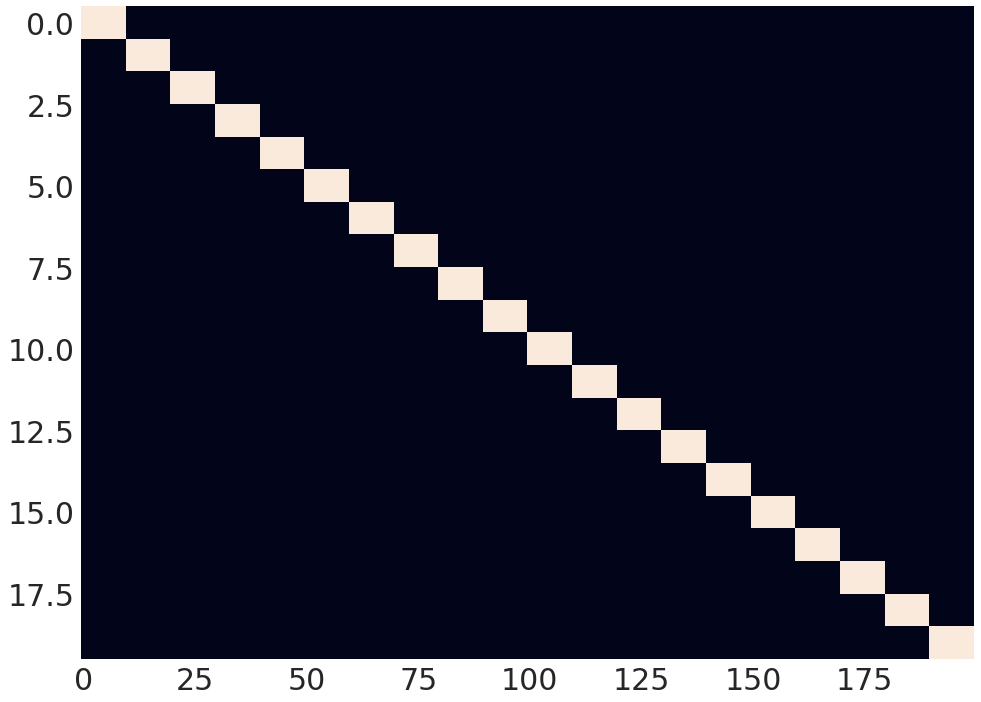

In [8]:
all_patterns = [patterns_dictionary[i] for i in range(number_of_patterns)]
all_patterns = np.array(all_patterns)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.grid()
ax.imshow(all_patterns, aspect='auto');

#### The dynamic equation
I will build now one step of the evolution

In [9]:
x = patterns_dictionary[0]
# Given that the input is not modify
s = np.sum(x)

# Intiailize the value of z and w
z_r = np.zeros(n)
w = np.ones((n, n))
a = np.ones((n, n))
m = np.sum(z_r)

modified_input = np.zeros(n)
modified_input[np.where(x == 1)[0]] = 1.0
inhibition_r = Ki * s + Kr * m
y_r = v * modified_input + np.dot(c1 * w, z_r) - inhibition_r
z_r = (y_r > theta).astype('float')

In [10]:
modified_input

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

We see that this passed the value of the input. This makes sense because there is no real recurrent connectivity effects and this just copies the input.

Now, let's build the dynamic equation for the CA1 output

In [11]:
inhibition_out = Ci * s + Cr * m
y_out = b * x + np.dot(c2 * a, z_r) - inhibition_out
z_out = (y_out > phi).astype('float')

m = np.sum(z_r)

In [12]:
z_out

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

We have the outer layer just outputs the input

#### Learning rules

In [13]:
def post_synaptic(epsilon, w, z_post, z_pre):
    
    return w + epsilon * z_post * (z_pre - w)

def pre_synaptic(epsilon, w, z_post, z_pre):
    
    return w + epsilon * z_pre * (z_post - w)

Let's study the learning rules, let's start with the pre-synaptic one. First it is important to realize that **z_pre needs to be activated** in order for it to be changedi n the pre-synaptic rule.

In [14]:
epsilon = 0.1

z_pre = 1
z_post = 0

w = np.random.rand()
w_history = []
for _ in range(100):
    w_history.append(w)
    w = pre_synaptic(epsilon, w, z_post, z_pre)

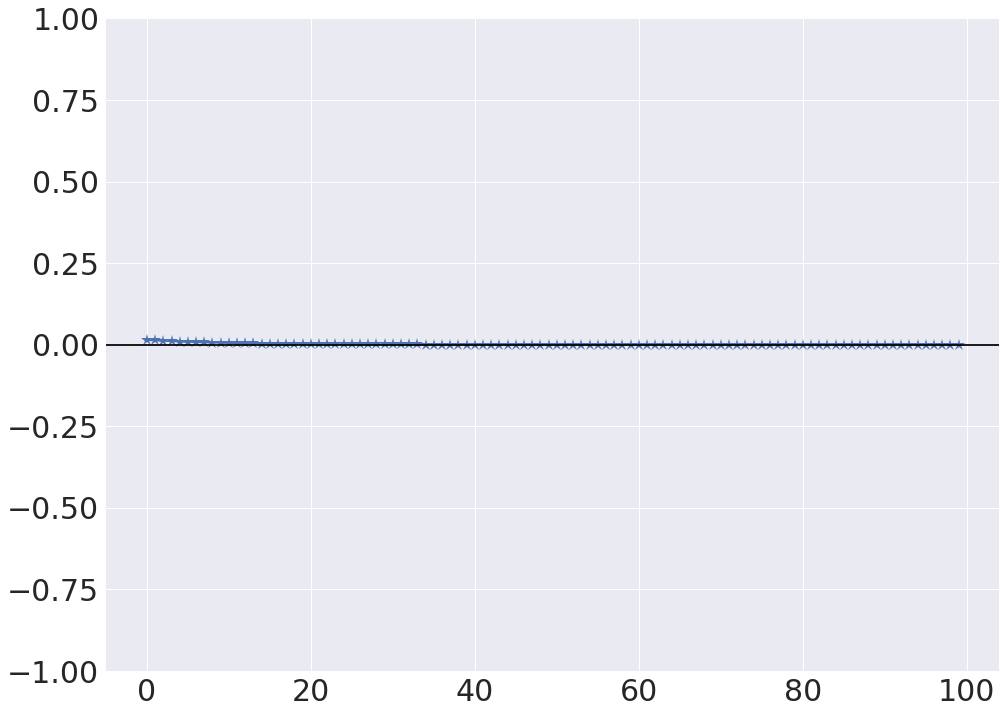

In [15]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ln = ax.plot(w_history, '*-', markersize=13)

ax.axhline(0, color='black')
ax.set_ylim([-1, 1]);

We see that if z_post = 0 is not activated the connection between them becomes very weak. Now let's see what happens if z_post=1

In [16]:
epsilon = 0.1

z_pre = 1
z_post = 1

w = np.random.rand()
w_history = []
for _ in range(100):
    w_history.append(w)
    w = pre_synaptic(epsilon, w, z_post, z_pre)

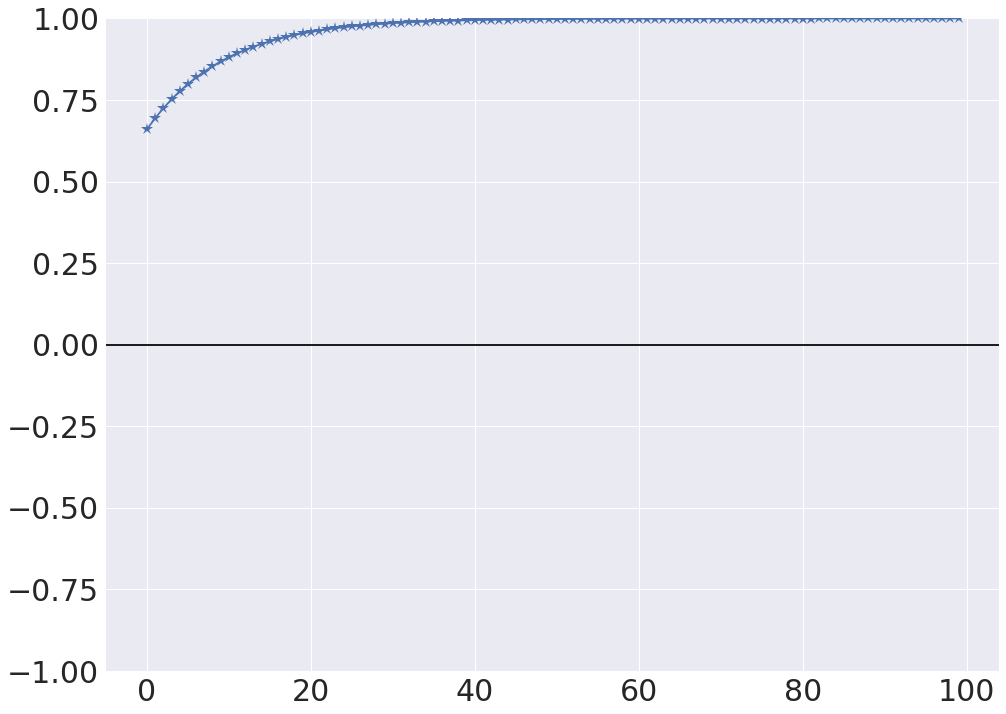

In [17]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ln = ax.plot(w_history, '*-', markersize=13)

ax.axhline(0, color='black')
ax.set_ylim([-1, 1]);

Now let's study the **post_synaptic rule** in this case is z_pre the one that needs to be different from 0.

In [18]:
time = 100
epsilon = 0.1

z_pre = 0
z_post = 1

w = np.random.rand()
w_history = []
for _ in range(time):
    w_history.append(w)
    w = post_synaptic(epsilon, w, z_post, z_pre)

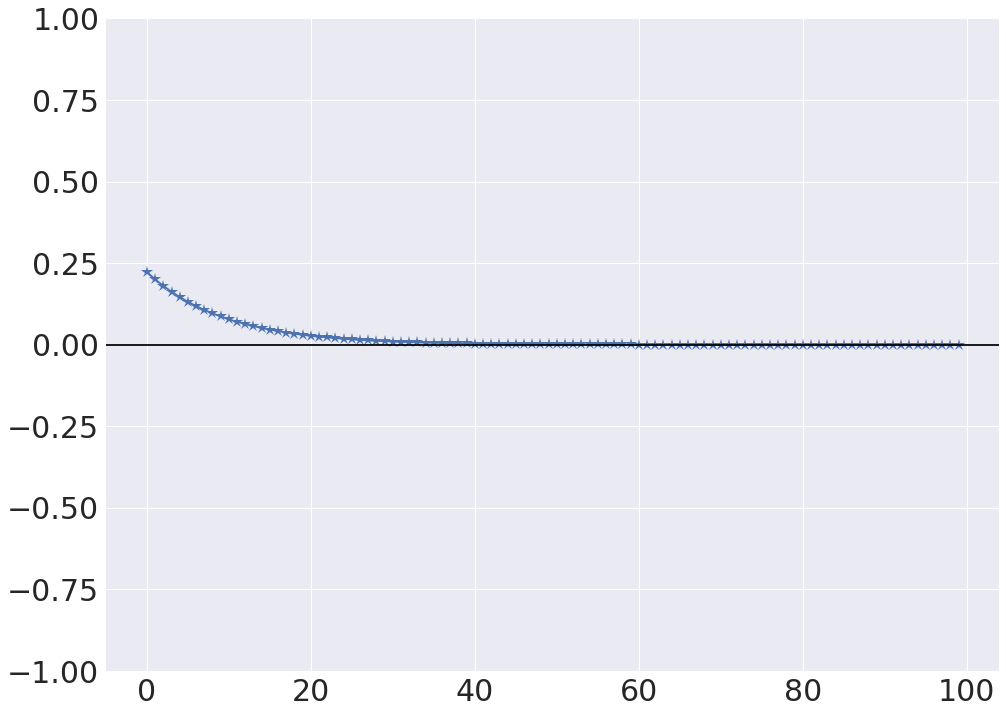

In [19]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ln = ax.plot(w_history, '*-', markersize=13)

ax.axhline(0, color='black')
ax.set_ylim([-1, 1]);

#### Training
First let's do simple some iterations over a particular pattern

In [20]:
training_time = 10
epsilon = 0.001

x = patterns_dictionary[0]
# Intiailize the value of z and w

small_value = 0.1
w = np.ones((n, n)) * small_value 
# w = np.random.rand(n, n)
a = np.ones((N, n)) * small_value
# a = np.random.rand(N, n)

z_out = np.zeros(N)
z_r = np.zeros(n)
m = np.sum(z_r)

for _ in range(training_time):
    # Input variables
    s = np.sum(x)
    modified_input = np.zeros(n)
    modified_input[np.where(x == 1)[0]] = 1.0
    
    # Update values for the C3
    inhibition_r = Ki * s + Kr * m
    y_r = v * modified_input + np.dot(c1 * w, z_r) - inhibition_r
    z_r_pre = np.copy(z_r)
    z_r = (y_r > theta).astype('float')
    
    # Update values for C1
    inhibition_out = Ci * s + Cr * m
    y_out = b * x + np.dot(c2 * a, z_r) - inhibition_out
    z_out_pre = np.copy(z_out) 
    z_out = (y_out > phi).astype('float')
    
    # Update dynamical values
    m = np.sum(z_r)
    # Presynaptic rules
    w = pre_synaptic(epsilon=epsilon, w=w, z_post=z_r, z_pre=z_r_pre)
    a = pre_synaptic(epsilon=epsilon, w=a, z_post=z_out, z_pre=z_r_pre)

In [21]:
a.shape

(200, 200)

Now let's do iterations over the whole sequence

In [22]:
# Structure paramters
N = 200  # Inputs size
n = 200  # C3 size
v = 21.0   # Input - C3 connection
b = 21.0   # Input - C1 connection
Kr = 1.0   # Recurrent self-inhibition gain
Ki = 1.0   # Input - C3 inhibition
Ci = 1.0  # Inhibition from the input to C1
Cr = 1.0  # Inhibition from C3 to C1
p = 0.4   # Sparness parameter

# Dynamical parameters
theta = 0.0
phi = 0


training_time = 10
epsilon = 0.1

x = patterns_dictionary[0]
# Intiailize the value of z and w

small_value = 0.1
w = np.ones((n, n)) * small_value 
# w = np.random.rand(n, n)
a = np.zeros((N, n))

y_r = np.zeros(n)
z_r = np.zeros(n)
m = np.sum(z_r)

y_out = np.zeros(N)
z_out = np.zeros(N)


m_history = []
w_history = []
inhibition_r_history = []
inhibition_out_history = []

c1 = np.ones((n, n))

sequence = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for _ in range(training_time):
    y_r = np.zeros(n)
    z_r = np.zeros(n)
    m = np.sum(z_r)

    y_out = np.zeros(N)
    z_out = np.zeros(N)
    for sequence_number in sequence:        
        # Input variables
        x = patterns_dictionary[sequence_number]       
        s = np.sum(x)
        modified_input = np.zeros(n)
        modified_input[np.where(x == 1)[0]] = 1.0

        # Update values for the C3
        inhibition_r = Ki * s + Kr * m
        y_r = v * modified_input + np.dot(c1 * w, z_r) - inhibition_r
        z_r_pre = np.copy(z_r)
        z_r = (y_r > theta).astype('float')
        if False:
            print('z_r')
            print(z_r)

        # Update values for C1
        inhibition_out = Ci * s + Cr * m
        y_out = b * x + np.dot(c2 * a, z_r) - inhibition_out
        z_out_pre = np.copy(z_out) 
        z_out = (y_out > phi).astype('float')

        # Update dynamical values
        m = np.sum(z_r)
        # Presynaptic rules
        w = pre_synaptic(epsilon=epsilon, w=w, z_post=z_r, z_pre=z_r_pre)
        a = pre_synaptic(epsilon=epsilon, w=a, z_post=z_out, z_pre=z_r_pre)
        # post-synaptic rules
        #w = post_synaptic(epislon=epislon, w=w, z_post=z_r, z_pre=z_r_pre)
        
        # History
        m_history.append(m)
        w_history.append(w.mean())
        inhibition_r_history.append(inhibition_r)
        inhibition_out_history.append(inhibition_out)

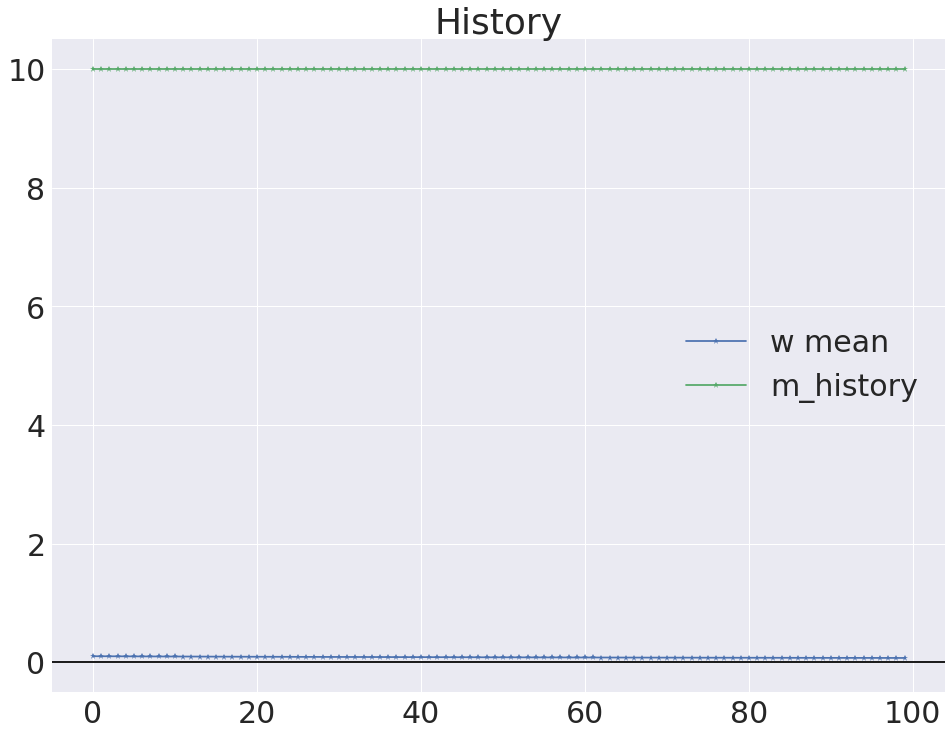

In [23]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.axhline(0, color='black')

ax.plot(w_history, '*-', label='w mean')
ax.plot(m_history, '*-', label='m_history')
ax.set_title('History')


ax.legend();

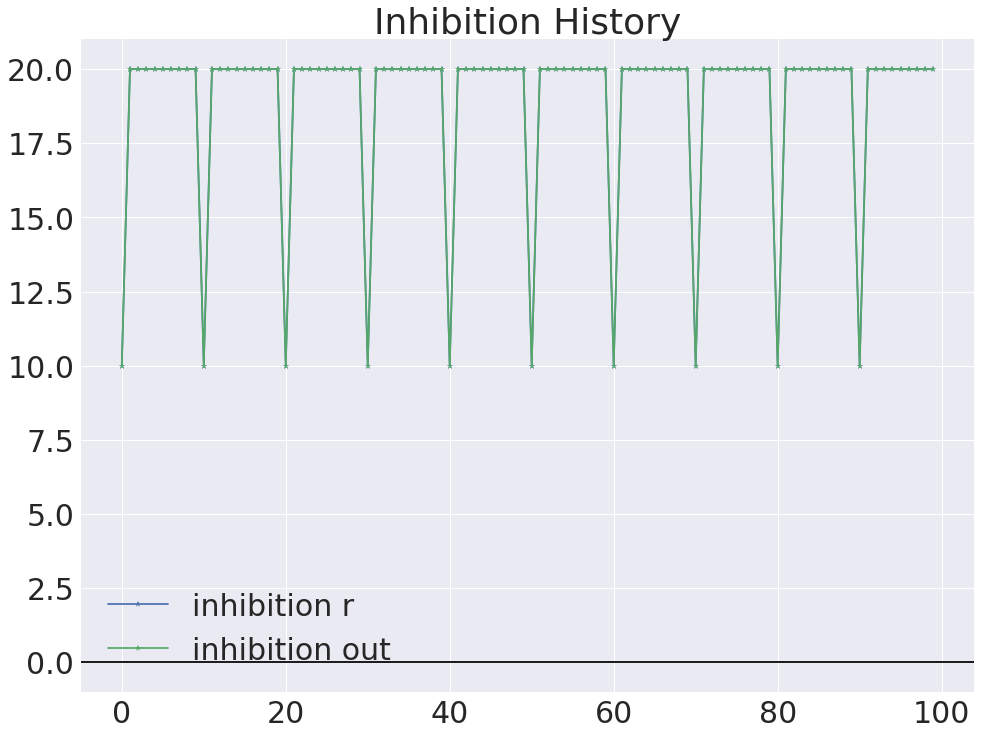

In [24]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.axhline(0, color='black')

ax.plot(inhibition_r_history, '*-', label='inhibition r')
ax.plot(inhibition_out_history, '*-', label='inhibition out')

ax.set_title('Inhibition History')
ax.legend();

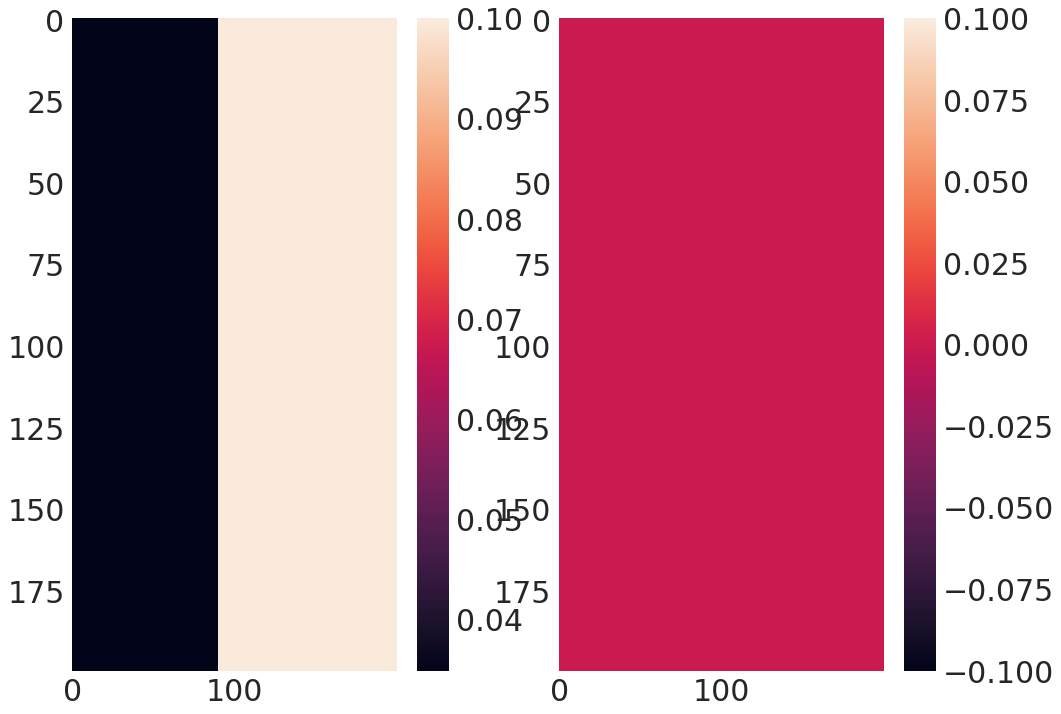

In [25]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(w, aspect='auto')
ax1.grid()

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(a, aspect='auto')
ax2.grid()

fig.colorbar(im1, ax=ax1);
fig.colorbar(im2, ax=ax2);

It seems that w and a are equal, but what is happeing is that only the first 50 values are being modified. The thing is that we are only using the first 50 values for the input.

Let's see if they are actually equal

In [26]:
np.linalg.norm(a - w)

15.552613858329483

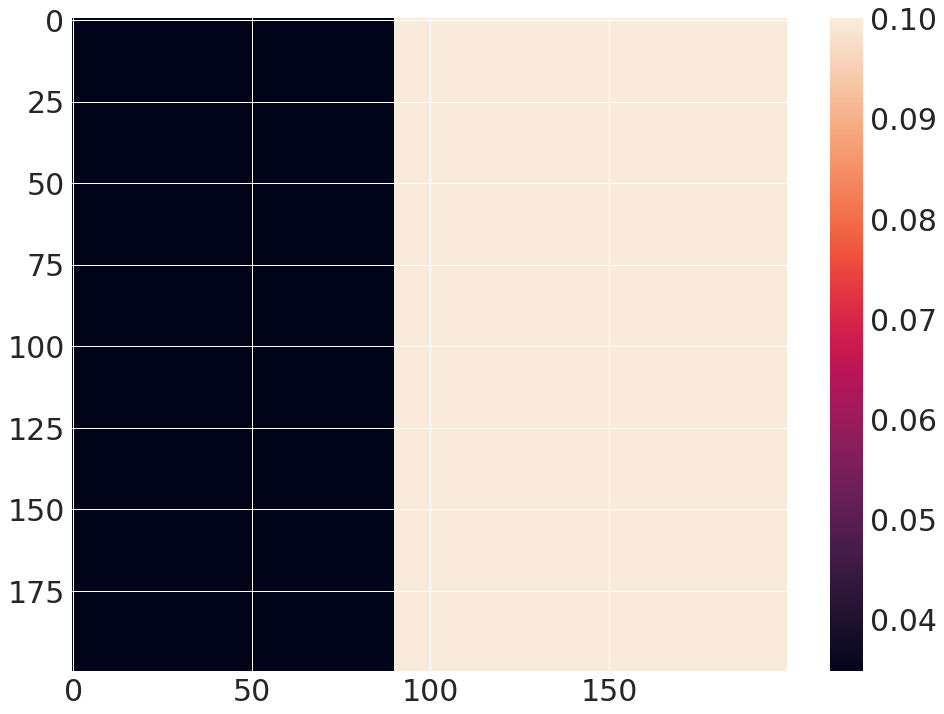

In [27]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
im = ax.imshow(np.abs(w - a), aspect='auto')
fig.colorbar(im);

Let's code the recall process

In [28]:
# Set neurons to zero
z_out = np.zeros(N)
z_r = np.zeros(n)
m = np.sum(z_r)

x = patterns_dictionary[sequence[0]]
for _ in range(1):
    s = np.sum(x)
    modified_input = np.zeros(n)
    modified_input[np.where(x == 1)[0]] = 1.0

    # Update values for the C3
    inhibition_r = Ki * s + Kr * m
    y_r = v * modified_input + np.dot(c1 * w, z_r) - inhibition_r
    z_r_pre = np.copy(z_r)
    z_r = (y_r > theta).astype('float')

    # Update values for C1
    inhibition_out = Ci * s + Cr * m
    y_out = b * x + np.dot(c2 * a, z_r) - inhibition_out
    z_out_pre = np.copy(z_out) 
    z_out = (y_out > phi).astype('float')

    # Update dynamical values
    m = np.sum(z_r)

print(z_out)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]


#### Repairing this mess
For some reason this does not seem to be working. A strategy to take is to follow the connections between the first and the second connection in a network that only trains between connections fro the two of them and see what happens. I suspect that it has to do with adjusting the total level of inhibition and moreover the input from the input layer.

In [29]:
# Structure paramters
N = 200  # Inputs size
n = 200  # C3 size
v = 21.0   # Input - C3 connection
b = 21.0   # Input - C1 connection
Kr = 1.0   # Recurrent self-inhibition gain
Ki = 1.0   # Input - C3 inhibition
Ci = 1.0  # Inhibition from the input to C1
Cr = 1.0  # Inhibition from C3 to C1
p = 0.4   # Sparness parameter

# Dynamical parameters
theta = 0.0
phi = 0


training_time = 10
epsilon = 0.1

x = patterns_dictionary[0]
# Intiailize the value of z and w

small_value = 0.1
w = np.ones((n, n)) * small_value 
# w = np.random.rand(n, n)
a = np.zeros((N, n))

y_r = np.zeros(n)
z_r = np.zeros(n)
m = np.sum(z_r)

y_out = np.zeros(N)
z_out = np.zeros(N)


m_history = []
w_history = []
inhibition_r_history = []
inhibition_out_history = []

c1 = np.ones((n, n))
print('initial', w[11, 0])

sequence = [0, 1]
for _ in range(training_time):
    y_r = np.zeros(n)
    z_r = np.zeros(n)
    m = np.sum(z_r)

    y_out = np.zeros(N)
    z_out = np.zeros(N)
    for sequence_number in sequence:        
        # Input variables
        x = patterns_dictionary[sequence_number]       
        s = np.sum(x)
        modified_input = np.zeros(n)
        modified_input[np.where(x == 1)[0]] = 1.0

        # Update values for the C3
        inhibition_r = Ki * s + Kr * m
        y_r = v * modified_input + np.dot(c1 * w, z_r) - inhibition_r
        z_r_pre = np.copy(z_r)
        z_r = (y_r > theta).astype('float')


        # Update values for C1
        inhibition_out = Ci * s + Cr * m
        y_out = b * x + np.dot(c2 * a, z_r) - inhibition_out
        z_out_pre = np.copy(z_out) 
        z_out = (y_out > phi).astype('float')

        # Update dynamical values
        m = np.sum(z_r)
        # Presynaptic rules
        w = pre_synaptic(epsilon=epsilon, w=w, z_post=z_r, z_pre=z_r_pre)
        a = pre_synaptic(epsilon=epsilon, w=a, z_post=z_out, z_pre=z_r_pre)
        # post-synaptic rules
        #w = post_synaptic(epislon=epislon, w=w, z_post=z_r, z_pre=z_r_pre)
        
        # History
        aux1 = w[11, 0]
        print('z_pre', z_r_pre[0])
        print('z_post', z_r[11])
        print('w[11, 0]', aux1)
        

        m_history.append(w[0, 11])
        w_history.append(w[11, 0])
        inhibition_r_history.append(inhibition_r)
        inhibition_out_history.append(inhibition_out)

initial 0.1
z_pre 0.0
z_post 0.0
w[11, 0] 0.1
z_pre 1.0
z_post 1.0
w[11, 0] 0.09
z_pre 0.0
z_post 0.0
w[11, 0] 0.09
z_pre 1.0
z_post 1.0
w[11, 0] 0.081
z_pre 0.0
z_post 0.0
w[11, 0] 0.081
z_pre 1.0
z_post 1.0
w[11, 0] 0.0729
z_pre 0.0
z_post 0.0
w[11, 0] 0.0729
z_pre 1.0
z_post 1.0
w[11, 0] 0.06561
z_pre 0.0
z_post 0.0
w[11, 0] 0.06561
z_pre 1.0
z_post 1.0
w[11, 0] 0.059049
z_pre 0.0
z_post 0.0
w[11, 0] 0.059049
z_pre 1.0
z_post 1.0
w[11, 0] 0.0531441
z_pre 0.0
z_post 0.0
w[11, 0] 0.0531441
z_pre 1.0
z_post 1.0
w[11, 0] 0.04782969
z_pre 0.0
z_post 0.0
w[11, 0] 0.04782969
z_pre 1.0
z_post 1.0
w[11, 0] 0.043046721
z_pre 0.0
z_post 0.0
w[11, 0] 0.043046721
z_pre 1.0
z_post 1.0
w[11, 0] 0.0387420489
z_pre 0.0
z_post 0.0
w[11, 0] 0.0387420489
z_pre 1.0
z_post 1.0
w[11, 0] 0.03486784401


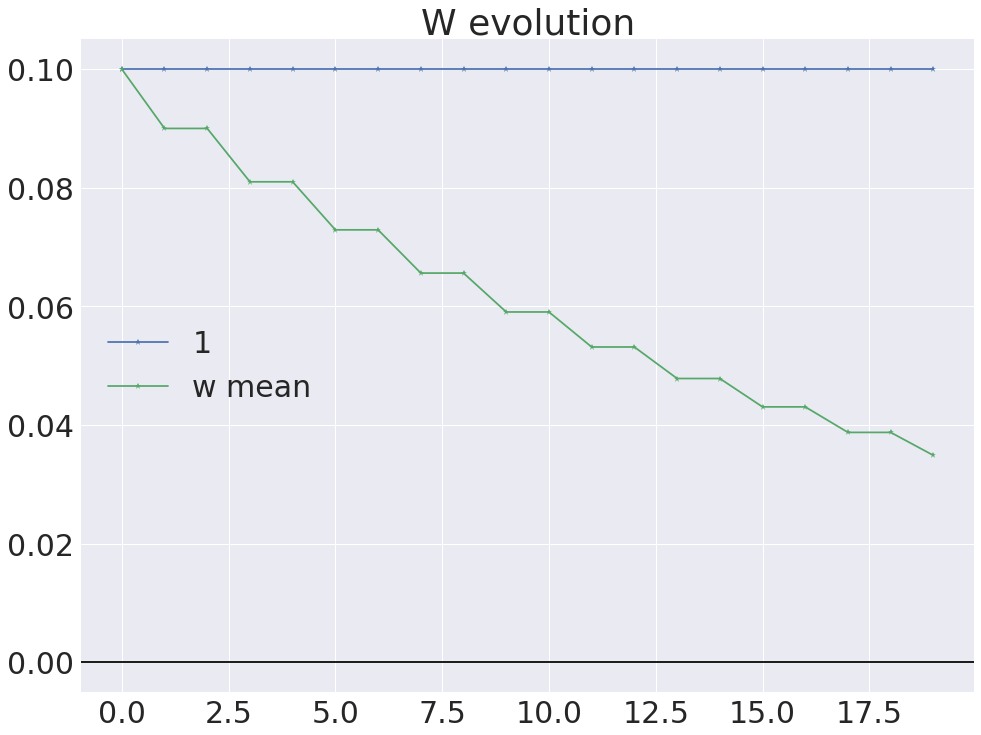

In [30]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.axhline(0, color='black')

ax.plot(m_history, '*-', label='1')
ax.plot(w_history, '*-', label='w mean')
ax.set_title('W evolution')


ax.legend();

Turns out that the problem is that the learning rules are not properly vectorized, lets just do that
#### Vectorizing the learning rules

In [31]:
def pre_synaptic_simple(epsilon, w, z_post, z_pre):
    increase = np.zeros_like(w)
    
    n = w.shape[0]
    for i in range(n):
        for j in range(n):
            increase[i, j] = z_pre[j] * z_post[i] - z_pre[j] * w[i, j]
    
    return epsilon * increase

def pre_synaptic(epsilon, w, z_post, z_pre):
    
    return epsilon * (np.outer(z_post, z_pre) - w * z_pre)

def post_synaptic(epsilon, w, z_post, z_pre):
    
    return epsilon * (np.outer(z_pre, z_post) - z_post * w)

Let's compare the pre-synaptic rule to this new vecorized version

In [32]:
dimension = 3
z_pre = np.ones(dimension)
w = np.zeros((dimension, dimension))
z_post = np.ones(dimension)
epsilon = 0.5

aux1 = pre_synaptic_simple(epsilon, w, z_post, z_pre)
aux2 = pre_synaptic(epsilon, w, z_post, z_pre)

print('aux1', aux1)
print('aux2', aux2)

aux1 [[ 0.5  0.5  0.5]
 [ 0.5  0.5  0.5]
 [ 0.5  0.5  0.5]]
aux2 [[ 0.5  0.5  0.5]
 [ 0.5  0.5  0.5]
 [ 0.5  0.5  0.5]]


In [33]:
# Structure paramters
N = 200  # Inputs size
n = 200  # C3 size
v = 21.0   # Input - C3 connection
b = 21.0   # Input - C1 connection
Kr = 1.0   # Recurrent self-inhibition gain
Ki = 1.0   # Input - C3 inhibition
Ci = 1.0  # Inhibition from the input to C1
Cr = 1.0  # Inhibition from C3 to C1
p = 0.4   # Sparness parameter

# Dynamical parameters
theta = 0.0
phi = 0


training_time = 20
epsilon = 0.1

x = patterns_dictionary[0]
# Intiailize the value of z and w

small_value = 0.1
w = np.ones((n, n)) * small_value 
# w = np.random.rand(n, n)
a = np.zeros((N, n))

y_r = np.zeros(n)
z_r = np.zeros(n)
m = np.sum(z_r)

y_out = np.zeros(N)
z_out = np.zeros(N)


m_history = []
w_history = []
inhibition_r_history = []
inhibition_out_history = []

c1 = np.ones((n, n))
print('initial', w[11, 0])

sequence = [0, 1]
for _ in range(training_time):
    y_r = np.zeros(n)
    z_r = np.zeros(n)
    m = np.sum(z_r)

    y_out = np.zeros(N)
    z_out = np.zeros(N)
    for sequence_number in sequence:        
        # Input variables
        x = patterns_dictionary[sequence_number]       
        s = np.sum(x)
        modified_input = np.zeros(n)
        modified_input[np.where(x == 1)[0]] = 1.0

        # Update values for the C3
        inhibition_r = Ki * s + Kr * m
        y_r = v * modified_input + np.dot(c1 * w, z_r) - inhibition_r
        z_r_pre = np.copy(z_r)
        z_r = (y_r > theta).astype('float')


        # Update values for C1
        inhibition_out = Ci * s + Cr * m
        y_out = b * x + np.dot(c2 * a, z_r) - inhibition_out
        z_out_pre = np.copy(z_out) 
        z_out = (y_out > phi).astype('float')

        # Update dynamical values
        m = np.sum(z_r)
        # Presynaptic rules
        aux = pre_synaptic_simple(epsilon=epsilon, w=w, z_post=z_r, z_pre=z_r_pre)
        w += pre_synaptic(epsilon=epsilon, w=w, z_post=z_r, z_pre=z_r_pre)
        a += pre_synaptic(epsilon=epsilon, w=a, z_post=z_out, z_pre=z_r_pre)
        # post-synaptic rules
        #w = post_synaptic(epislon=epislon, w=w, z_post=z_r, z_pre=z_r_pre)
        
        # History
        aux1 = w[11, 0]
        print('z_pre', z_r_pre[0])
        print('z_post', z_r[11])
        print('w[11, 0]', aux1)
        print('aux', aux[11, 0])
        

        m_history.append(w[0, 11])
        w_history.append(w[11, 0])
        inhibition_r_history.append(inhibition_r)
        inhibition_out_history.append(inhibition_out)

initial 0.1
z_pre 0.0
z_post 0.0
w[11, 0] 0.1
aux 0.0
z_pre 1.0
z_post 1.0
w[11, 0] 0.19
aux 0.09
z_pre 0.0
z_post 0.0
w[11, 0] 0.19
aux 0.0
z_pre 1.0
z_post 1.0
w[11, 0] 0.271
aux 0.081
z_pre 0.0
z_post 0.0
w[11, 0] 0.271
aux 0.0
z_pre 1.0
z_post 1.0
w[11, 0] 0.3439
aux 0.0729
z_pre 0.0
z_post 0.0
w[11, 0] 0.3439
aux 0.0
z_pre 1.0
z_post 1.0
w[11, 0] 0.40951
aux 0.06561
z_pre 0.0
z_post 0.0
w[11, 0] 0.40951
aux 0.0
z_pre 1.0
z_post 1.0
w[11, 0] 0.468559
aux 0.059049
z_pre 0.0
z_post 0.0
w[11, 0] 0.468559
aux 0.0
z_pre 1.0
z_post 1.0
w[11, 0] 0.5217031
aux 0.0531441
z_pre 0.0
z_post 0.0
w[11, 0] 0.5217031
aux 0.0
z_pre 1.0
z_post 1.0
w[11, 0] 0.56953279
aux 0.04782969
z_pre 0.0
z_post 0.0
w[11, 0] 0.56953279
aux 0.0
z_pre 1.0
z_post 1.0
w[11, 0] 0.612579511
aux 0.043046721
z_pre 0.0
z_post 0.0
w[11, 0] 0.612579511
aux 0.0
z_pre 1.0
z_post 1.0
w[11, 0] 0.6513215599
aux 0.0387420489
z_pre 0.0
z_post 0.0
w[11, 0] 0.6513215599
aux 0.0
z_pre 1.0
z_post 1.0
w[11, 0] 0.68618940391
aux 0.03486

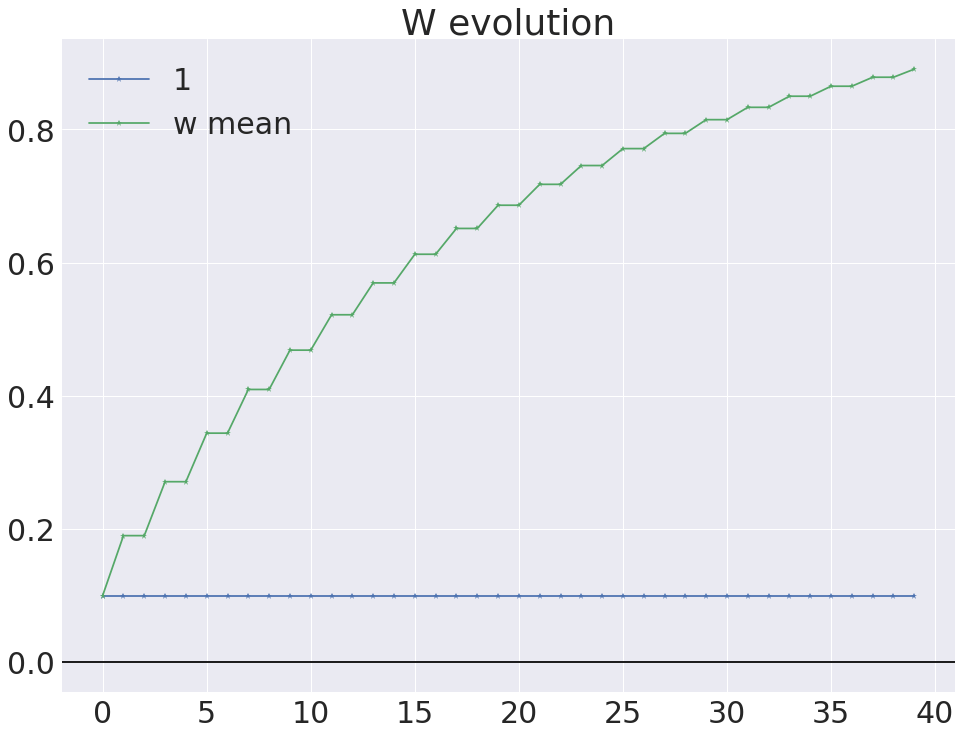

In [34]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.axhline(0, color='black')

ax.plot(m_history, '*-', label='1')
ax.plot(w_history, '*-', label='w mean')
ax.set_title('W evolution')


ax.legend();

This seems to be working, let's try now we more sequences

In [71]:
# Structure paramters
N = 200  # Inputs size
n = 200  # C3 size
v = 21.0   # Input - C3 connection
b = 21.0   # Input - C1 connection
Kr = 1.0   # Recurrent self-inhibition gain
Ki = 1.0   # Input - C3 inhibition
Ci = 1.0  # Inhibition from the input to C1
Cr = 1.0  # Inhibition from C3 to C1
p = 0.4   # Sparness parameter

# Dynamical parameters
theta = 0.0
phi = 0


training_time = 100
epsilon = 0.1

small_value = 0.1
w = np.ones((n, n)) * small_value 
w = np.random.rand(n, n)
a = np.zeros((N, n))

m_history = []
w_history = []
inhibition_r_history = []
inhibition_out_history = []

c1 = np.ones((n, n))
c2 = np.ones((n, N))

sequence = [0, 1, 2, 3, 4, 5, 6]
for _ in range(training_time):
    y_r = np.zeros(n)
    z_r = np.zeros(n)
    m = np.sum(z_r)

    y_out = np.zeros(N)
    z_out = np.zeros(N)
    for sequence_number in sequence:        
        # Input variables
        x = patterns_dictionary[sequence_number]       
        s = np.sum(x)
        modified_input = np.zeros(n)
        modified_input[np.where(x == 1)[0]] = 1.0

        # Update values for the C3
        inhibition_r = Ki * s + Kr * m
        y_r = v * modified_input + np.dot(c1 * w, z_r) - inhibition_r
        z_r_pre = np.copy(z_r)
        z_r = (y_r > theta).astype('float')


        # Update values for C1
        inhibition_out = Ci * s + Cr * m
        y_out = b * x + np.dot(c2 * a, z_r) - inhibition_out
        z_out_pre = np.copy(z_out) 
        z_out = (y_out > phi).astype('float')

        # Update dynamical values
        m = np.sum(z_r)
        # Presynaptic rules
        # aux = pre_synaptic_simple(epsilon=epsilon, w=w, z_post=z_r, z_pre=z_r_pre)
        w += pre_synaptic(epsilon=epsilon, w=w, z_post=z_r, z_pre=z_r_pre)
        a += pre_synaptic(epsilon=epsilon, w=a, z_post=z_out, z_pre=z_r_pre)
        # post-synaptic rules
        #w = post_synaptic(epislon=epislon, w=w, z_post=z_r, z_pre=z_r_pre)
        
        # History

        m_history.append(m)
        w_history.append(w[11, 0])
        inhibition_r_history.append(inhibition_r)
        inhibition_out_history.append(inhibition_out)

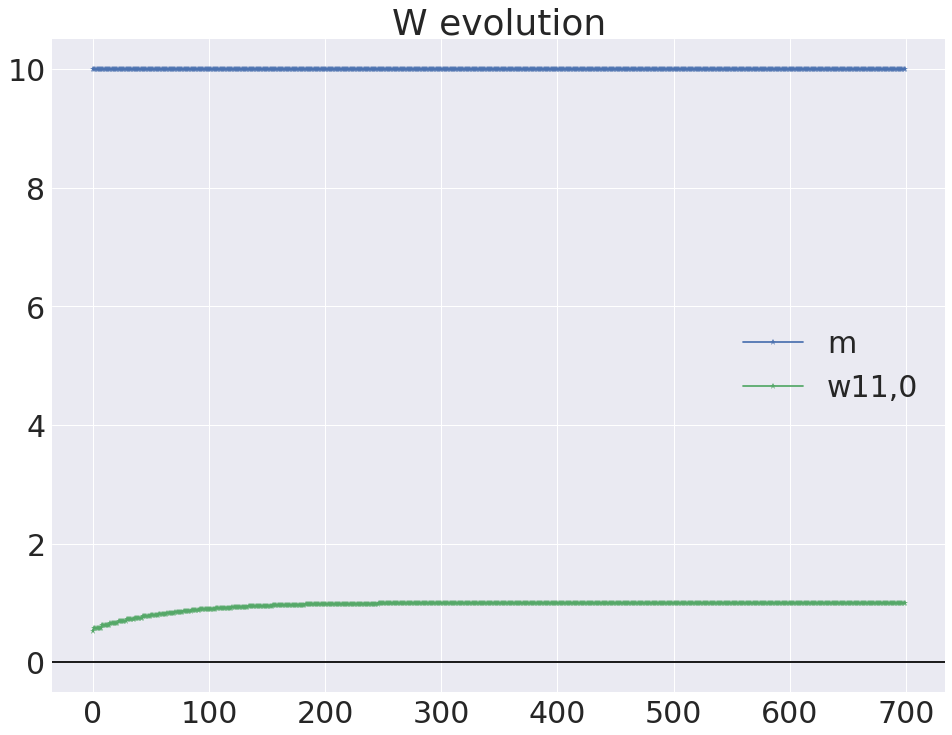

In [72]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.axhline(0, color='black')

ax.plot(m_history, '*-', label='m')
ax.plot(w_history, '*-', label='w11,0')
ax.set_title('W evolution')


ax.legend();

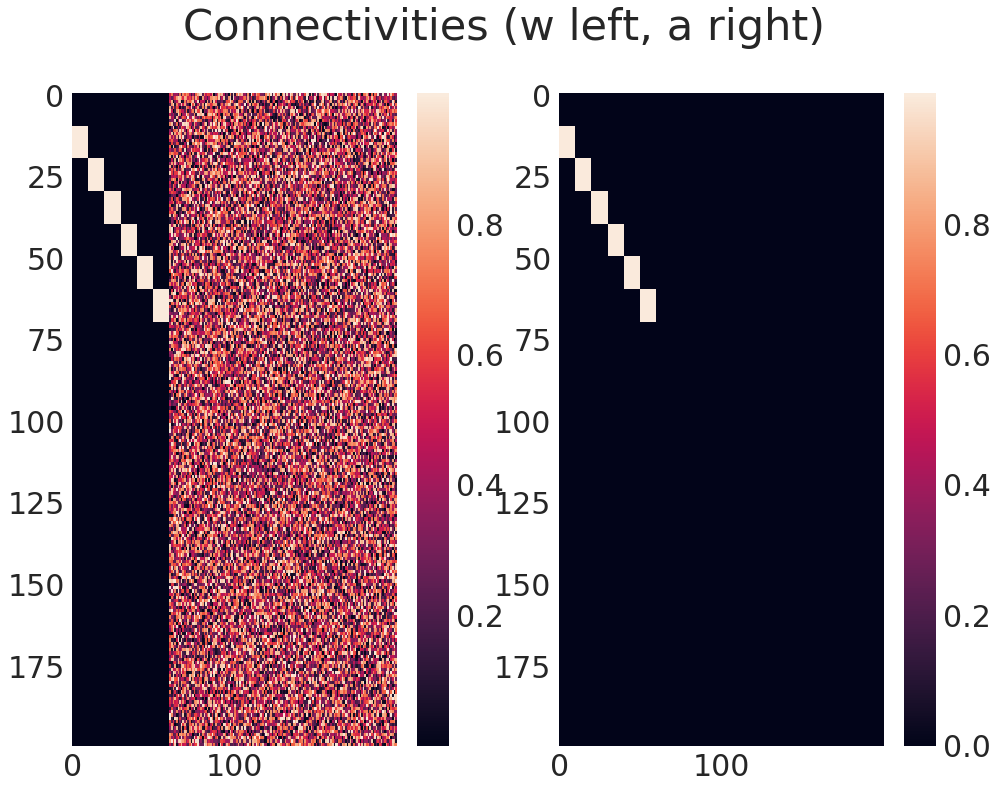

In [73]:
fig = plt.figure(figsize=(16, 12))

fig.suptitle('Connectivities (w left, a right)')

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(w, aspect='auto')
ax1.grid()

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(a, aspect='auto')
ax2.grid()

fig.colorbar(im1, ax=ax1);
fig.colorbar(im2, ax=ax2);

This makes far more sense, let's try to recall

In [44]:
x = patterns_dictionary[0] 

for _ in range(6):
    y_r = np.zeros(n)
    z_r = np.zeros(n)
    m = np.sum(z_r)

    y_out = np.zeros(N)
    z_out = np.zeros(N)
       
    # Input variables
          
    s = np.sum(x)
    modified_input = np.zeros(n)
    modified_input[np.where(x == 1)[0]] = 1.0

    # Update values for the C3
    inhibition_r = Ki * s + Kr * m
    y_r = v * modified_input + np.dot(c1 * w, z_r) - inhibition_r
    z_r_pre = np.copy(z_r)
    z_r = (y_r > theta).astype('float')


    # Update values for C1
    inhibition_out = Ci * s + Cr * m
    y_out = b * x + np.dot(c2 * a, z_r) - inhibition_out
    z_out_pre = np.copy(z_out) 
    z_out = (y_out > phi).astype('float')

    # Update dynamical values
    m = np.sum(z_r)
    x = np.zeros(n)
    
    print('z_out', z_out)

z_out [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
z_out [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. 

I suspect that the system is not working because the recurrent inhibition is way too big compared to the effect of recurrent so the system ends up being killed. Let's separte the system more carefuly to separte the effects of excitation, recurrent excitation and inhibition

In [60]:
### Structure paramters
N = 200  # Inputs size
n = 200  # C3 size
v = 21.0   # Input - C3 connection
b = 21.0   # Input - C1 connection
Kr = 1.0   # Recurrent self-inhibition gain
Ki = 1.0   # Input - C3 inhibition
Ci = 1.0  # Inhibition from the input to C1
Cr = 1.0  # Inhibition from C3 to C1
p = 0.4   # Sparness parameter

# Dynamical parameters
theta = 0.0
phi = 0


training_time = 100
epsilon = 0.1

small_value = 0.1
#w = np.ones((n, n)) * small_value 
w = np.random.rand(n, n)
a = np.zeros((N, n))

m_history = []
w_history = []
input_excitation_history = []
inhibition_r_history = []
inhibition_out_history = []
excitation_r_history = []

c1 = bernoulli_mask(size_from=n, size_to=N, p=p, binomial=True)
c2 = bernoulli_mask(size_from=N, size_to=n, p=p, binomial=True)
c2 = np.ones((n, N))
c1 = np.ones((N, n))

sequence = [0, 1, 2, 3, 4, 5]
for _ in range(training_time):
    y_r = np.zeros(n)
    z_r = np.zeros(n)
    m = np.sum(z_r)

    y_out = np.zeros(N)
    z_out = np.zeros(N)
    for sequence_number in sequence:        
        # Input variables
        x = patterns_dictionary[sequence_number]       
        s = np.sum(x)
        modified_input = np.zeros(n)
        modified_input[np.where(x == 1)[0]] = 1.0

        # Update values for the C3
        inhibition_r = Ki * s + Kr * m
        recurrent_excitation_r = np.dot(c1 * w, z_r)
        input_excitation_r = v * modified_input
        y_r =  input_excitation_r + recurrent_excitation_r - inhibition_r
        z_r_pre = np.copy(z_r)
        z_r = (y_r > theta).astype('float')


        # Update values for C1
        inhibition_out = Ci * s + Cr * m
        y_out = b * x + np.dot(c2 * a, z_r) - inhibition_out
        z_out_pre = np.copy(z_out) 
        z_out = (y_out > phi).astype('float')

        # Update dynamical values
        m = np.sum(z_r)
        # Presynaptic rules
        # aux = pre_synaptic_simple(epsilon=epsilon, w=w, z_post=z_r, z_pre=z_r_pre)
        w += pre_synaptic(epsilon=epsilon, w=w, z_post=z_r, z_pre=z_r_pre)
        a += pre_synaptic(epsilon=epsilon, w=a, z_post=z_out, z_pre=z_r_pre)
        # post-synaptic rules
        #w = post_synaptic(epislon=epislon, w=w, z_post=z_r, z_pre=z_r_pre)
        
        # History
        index = 0
        m_history.append(m)
        input_excitation_history.append(input_excitation_r[index])
        excitation_r_history.append(recurrent_excitation_r[index])
        w_history.append(w[11, 0])
        inhibition_r_history.append(inhibition_r)
        inhibition_out_history.append(inhibition_out)

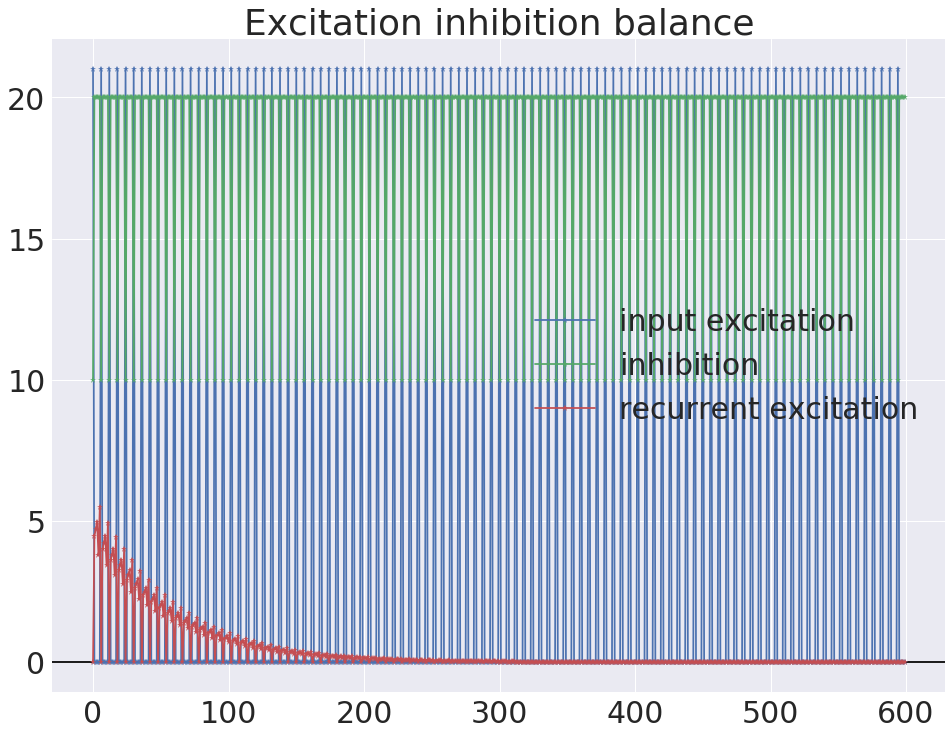

In [64]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.axhline(0, color='black')

ax.plot(input_excitation_history, '*-', label='input excitation')
ax.plot(inhibition_r_history, '*-', label='inhibition')
ax.plot(excitation_r_history, '*-', label='recurrent excitation')
ax.set_title('Excitation inhibition balance')


ax.legend();